## Finding Your Way In The City (Graph Edition)

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.


In order to make graph creation and manipulation simple, we are going to leverage a powerful package called [NetworkX](https://networkx.github.io/). With Networkx, it is easy to take the nodes and edges we found using the Voronoi and medial axis methods and arrange them into a single graph object.

In this exercise we will start with the Voronoi method to extract a graph where nodes and edges do not collide with obstacles. Then we will use NetworkX to build up a graph object. Then we Compute the path from start to goal locations through the graph using the A* algorithm.

Take a note at the number of steps and think of applying again a pruning techniques to make the path even smaller.

### Preliminar steps

In [1]:
# Import the latest version of networkx
# This occassionally fails, so if the next cell doesn't show that we are using networkx 2.1, "restart and
# clear output" from "Kernel" menu above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1

# import pkg_resources
# pkg_resources.require("networkx==2.1")

  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)


In [5]:
import networkx as nx
nx.__version__

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from queue import PriorityQueue
from bresenham import bresenham

from grid import create_grid_and_edges

%matplotlib inline

plt.rcParams['figure.figsize'] = 13, 13

### Read the obstacle map

In [3]:
# Read the obstacle data contained in the file: colliders.csv
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


### Create a grid configuration space for the given altitude and safety distance from the  obstacle data
### And a free-collision edges (using Voronoi and Brensenham mehtods)

Number of collision-free edges created: 1771


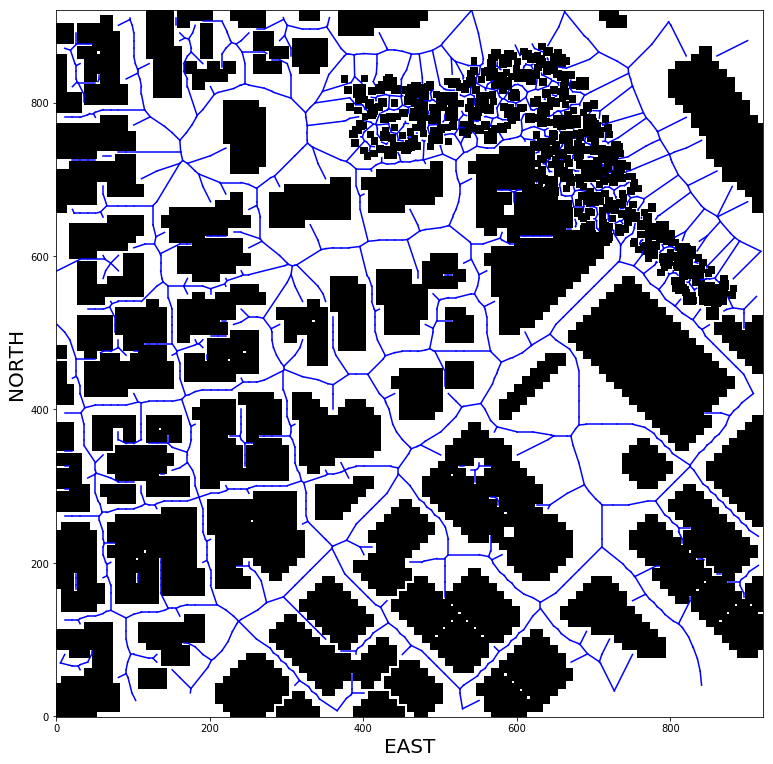

In [58]:
# Static drone altitude (meters)
drone_altitude = 7

# Minimum distance stay away from obstacle (meters)
safety_distance = 3

# Grid Configuration Space from obstacle data and free-collition edges
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print('Number of collision-free edges created:',len(edges))

# Plotting the edges on top of the grid along with start and goal locations.
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys')      # Grid Configuration Space

for e in edges:                                     # Edges
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'blue')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

### Transforming the set of collition-free edges into a graph (using NetworkX)

Now we have a graph, at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph for the whole set of collision-free edges.

**NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms. **NOTE:** In the initial import above it was imported with the `nx` alias.

In [59]:
# Create the graph with the weight of the edges set to the Euclidean distance between the points
G = nx.Graph()     # Graph creation

for edge in edges:  # for every edge in the Voronoi graph
    # extract the ends of the edge
    p1 = edge[0]
    p2 = edge[1]
    
    # calculate their euclidean distance between ends
    dist = LA.norm(np.array(p2) - np.array(p1))
    
    # add the edge to the NetworkX graph with a weight given by its euclidean distance
    G.add_edge(p1, p2, weight=dist)

### Heuristic Function
Note that for graphs-based, the "Manhattan distance" as a heuristic no longer makes sense, but Euclidean distance can still serve as a perfectly valid heuristic estimate for using with the A* algorithm.

In [60]:
def Euclidean_d(position, goal_position):
    dx = goal_position[0] - position[0]
    dy = goal_position[1] - position[1] 
    return ((dx**2 + dy**2)**0.5)

#def Manhattan_d(position, goal_position):
#    dx = goal_position[0] - position[0]
#    dy = goal_position[1] - position[1]
#    return (abs(dx) + abs(dy))

### Modified version of the A* to work with graphs
We need to adapt A* in order to be able to search a planning in a graph.

The notable differences with the A* algorithm for grids are that the actions are now the outgoing edges and the cost of an action is the weight (defined as its length=euclidean distance of its ends) of that edge.

In [61]:
# A* IMPLEMENTATION for graphs
def a_star(graph, h, start, goal):
    ''' A* implementation for dealing with graphs
    '''
    path = []
    path_cost = 0
    queue = PriorityQueue()   # Priority queue for prioritizing expanding cells with lower cost
    queue.put((0, start))     # (cost, cell); cost value is use for priority
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        # Get and remove the first element from the queue
        item = queue.get()
        current_node = item[1]
        
        # Assignation of current cost
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
        
        # If the current cell corresponds to the goal state, stop the search
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:               # For every node connected to the current node
                cost = graph.edges[current_node, next_node]['weight']   # extract cost(=weitgh value) to get there
                
                # Branch cost evaluation (action.cost + g)
                branch_cost = current_cost + cost
                
                # Heuristics distance evaluation
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))

    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


### Find the closest point in the graph to the start and goal locations.

In [62]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 10000000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

Original start / goal locations (north, east): (25, 850) / (880, 110)
Nearest points on collition-free graph:      (40.7611, 840.7685) / (880.7611, 100.76850000000002)


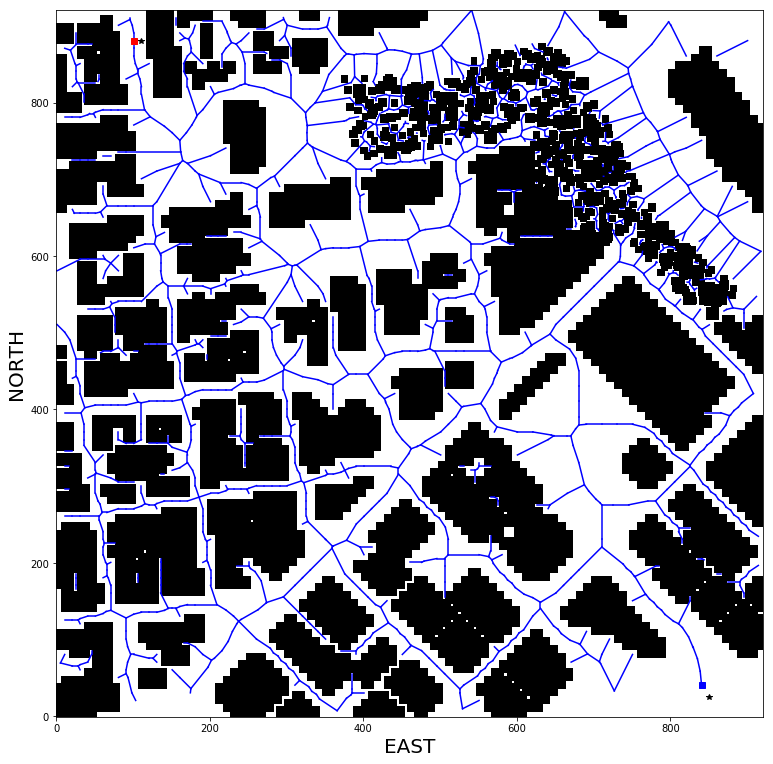

In [63]:
# Start and Goal locations
start_ne = (25,  850)
goal_ne = (880, 110)

# Calculation of closest point on graph for start and goal locations
start_ne_graph = closest_point(G, start_ne)
goal_ne_graph = closest_point(G, goal_ne)

print('Original start / goal locations (north, east): {} / {}'.format(start_ne, goal_ne))
print('Nearest points on collition-free graph:      {} / {}'.format(start_ne_graph, goal_ne_graph))

# Plotting

# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys')                # Grid Configuration Space

for e in edges:                                     # Edges
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'blue')

plt.plot(start_ne[1], start_ne[0], '*', color = 'black')            # Original start location
plt.plot(goal_ne[1], goal_ne[0], '*', color = 'black')              # Original goal location

plt.plot(start_ne_graph[1], start_ne_graph[0], 's', color = 'blue') # Closest-to-graph start location
plt.plot(goal_ne_graph[1], goal_ne_graph[0], 's', color = 'red')    # Closest-to-graph goal location

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

### Find the path from start to goal with A*

In [64]:
# Run A* on the graph
# A* consider there is a obstacle with 1; that is why we inverse the skeleton to have the medial_axis=0
# We also have to convert the skeleton from boolean value to integer
path, cost = a_star(G, Euclidean_d, start_ne_graph, goal_ne_graph)
print('Path length = {} steps \nPath cost = {:.1f}'.format(len(path), cost))

Found a path.
Path length = 116 steps 
Path cost = 1392.2


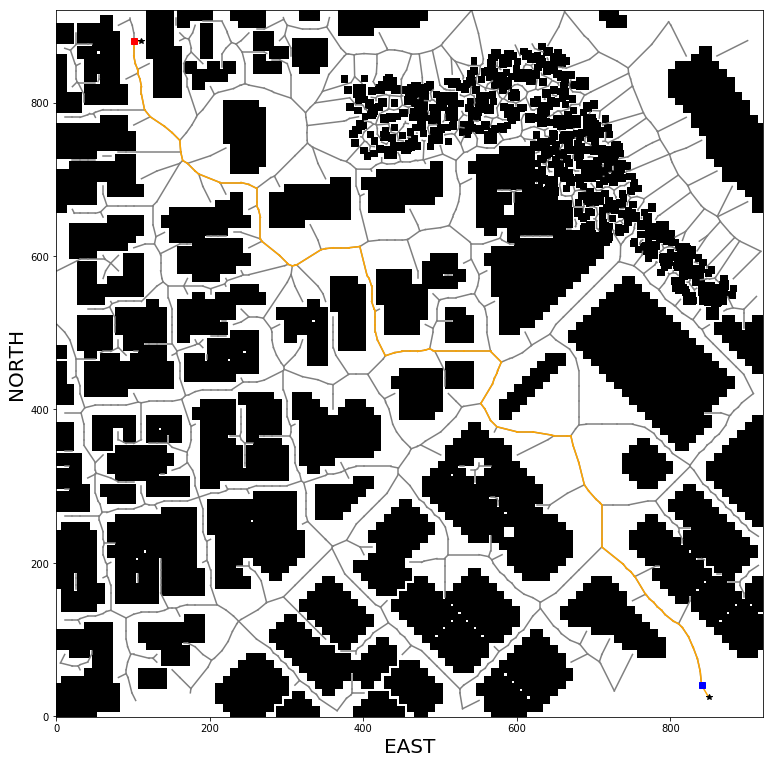

In [65]:
# Plotting

# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys')                # Grid Configuration Space

for e in edges:                                               # Plotting collition-free Edges
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'grey')
    
plt.plot([start_ne[1], start_ne_graph[1]], [start_ne[0], start_ne_graph[0]], 'orange')  # plotting from original to closest point
plt.plot([goal_ne[1], goal_ne_graph[1]], [goal_ne[0], goal_ne_graph[0]], 'orange')

for i in range(len(path)-1):                                  # Plotting path
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'orange')

plt.plot(start_ne[1], start_ne[0], '*', color = 'black')            # Original start location
plt.plot(goal_ne[1], goal_ne[0], '*', color = 'black')              # Original goal location

plt.plot(start_ne_graph[1], start_ne_graph[0], 's', color = 'blue') # Closest-to-graph start location
plt.plot(goal_ne_graph[1], goal_ne_graph[0], 's', color = 'red')    # Closest-to-graph goal location

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

### Prune the path even more
Remember we are dealing with a drone. Therefore there is no need to follow the "roads" given by the graphs but it can flight in straight lines between graph selected nodes providing there is no collision.

In [69]:
def prune_path(path,grid):
    '''Prune the path using Brensenham mehtod
       If the Brensenham line between a node and the next to the following one (n+2) in the path
       does not hit any obstacle, then the middle node (n+1) is removed from the path.
       '''    
    pruned_path = [p for p in path]   # Path to a list
    i = 0
    
    while i < len(pruned_path) - 2:
        p1 = pruned_path[i]
        p2 = pruned_path[i + 2]
        
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for cell in cells:
            # Check if we're in collision
            if grid[cell[0], cell[1]] == 1:
                hit = True
                break

        # If the edge does not hit an obstacle, remove the middle point
        if not hit:
            pruned_path.remove(pruned_path[i + 1])
        else:
            i += 1
            
    return pruned_path

In [70]:
# Prune the path
pruned_path=prune_path(path,grid)
print('Pruned Path length: {} \nOriginal Path length: {}'.format(len(pruned_path), len(path)))

Pruned Path length: 10 
Original Path length: 116


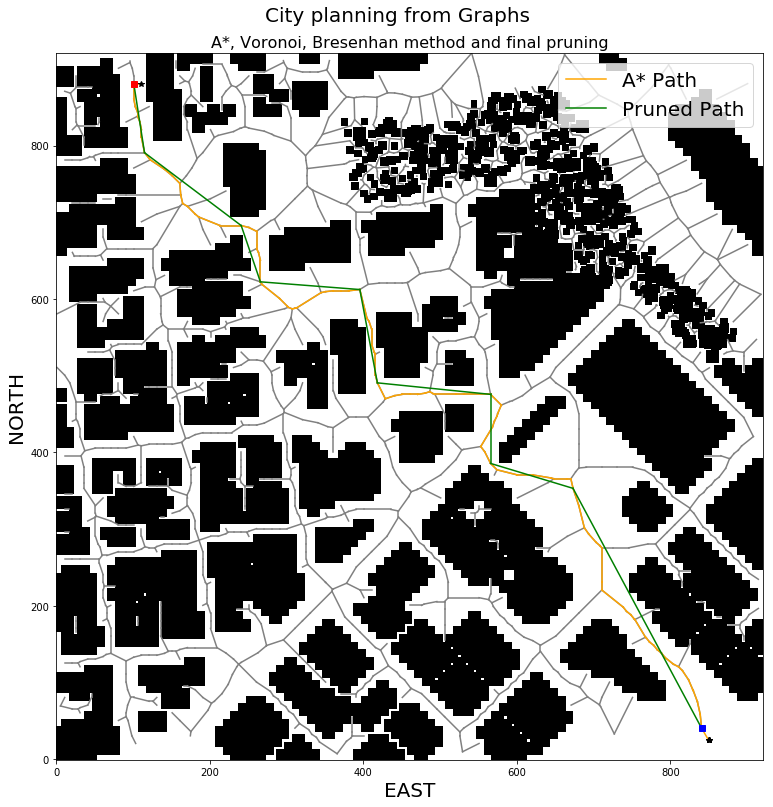

In [107]:
# Plotting

# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys')                # Grid Configuration Space

for e in edges:                                               # Plotting collition-free Edges
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'grey')
    
plt.plot([start_ne[1], start_ne_graph[1]], [start_ne[0], start_ne_graph[0]], 'orange')  # plotting from original to closest point
plt.plot([goal_ne[1], goal_ne_graph[1]], [goal_ne[0], goal_ne_graph[0]], 'orange')
    
for i in range(len(path)-1):                                  # Plotting path
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'orange', label='A* Path')

for i in range(len(pruned_path)-1):                                  # Plotting pruned_path
    p1 = pruned_path[i]
    p2 = pruned_path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'green', label='Pruned Path')

    plt.plot(start_ne[1], start_ne[0], '*', color = 'black')            # Original start location
plt.plot(goal_ne[1], goal_ne[0], '*', color = 'black')              # Original goal location

plt.plot(start_ne_graph[1], start_ne_graph[0], 's', color = 'blue') # Closest-to-graph start location
plt.plot(goal_ne_graph[1], goal_ne_graph[0], 's', color = 'red')    # Closest-to-graph goal location

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.suptitle('City planning from Graphs', fontsize=20, x=0.5, y=0.93)
plt.title('A*, Voronoi, Bresenhan method and final pruning', fontsize=16, x=0.5, y=1.0)

plt.legend(loc='upper right', fontsize=20)
plt.show()